In [1]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Part 2 imports
from part2.ml_comparison import (
    get_default_classifiers,
    prepare_data,
    run_model_comparison,
    generate_confusion_matrices,
    plot_confusion_matrices,
    plot_performance_comparison,
    create_summary_report
)

# Project imports
from config import PATHS

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load ML Matrices

In [2]:
# Paths
PART2_DIR = project_root / "output" / "part2"
GRAPHS_DIR = project_root / "graphs" / "part2"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# Find all ML matrix files
ml_files = list(PART2_DIR.glob("*_ml_matrix.csv"))

# Also include statistical SNPs from Part 1
stat_path = PATHS.OUTPUT_DIR / "statistical_ml_data_02b.csv"

print(f"Found {len(ml_files)} ML matrices in Part 2:")
for f in ml_files:
    print(f"  - {f.name}")

if stat_path.exists():
    print(f"\nAlso including: statistical_ml_data_02b.csv")

Found 2 ML matrices in Part 2:
  - cal_et_al_ml_matrix.csv
  - forenseq_ml_matrix.csv

Also including: statistical_ml_data_02b.csv


In [3]:
# Load all matrices
datasets = {}

for ml_file in ml_files:
    name = ml_file.stem.replace('_ml_matrix', '')
    df = pd.read_csv(ml_file)
    datasets[name] = df
    print(f"Loaded {name}: {df.shape}")

# Add statistical SNPs
if stat_path.exists():
    stat_df = pd.read_csv(stat_path)
    datasets['statistical_all4'] = stat_df
    print(f"Loaded statistical_all4: {stat_df.shape}")

print(f"\nTotal datasets: {len(datasets)}")

Loaded cal_et_al: (306, 54)
Loaded forenseq: (306, 57)
Loaded statistical_all4: (306, 39)

Total datasets: 3


## Step 2: Dataset Overview

In [4]:
# Create overview table
overview = []

for name, df in datasets.items():
    snp_cols = [c for c in df.columns if c not in ['sample', 'pop', 'source']]
    overview.append({
        'Source': name,
        'Samples': len(df),
        'SNPs': len(snp_cols),
        'Populations': df['pop'].nunique(),
        'Pop_List': ', '.join(df['pop'].unique())
    })

overview_df = pd.DataFrame(overview)
print("DATASET OVERVIEW")
print("="*80)
display(overview_df)

DATASET OVERVIEW


,Source,Samples,SNPs,Populations,Pop_List
0,cal_et_al,306,52,3,"KHV, CHB, JPT"
1,forenseq,306,55,3,"KHV, CHB, JPT"
2,statistical_all4,306,37,3,"KHV, CHB, JPT"


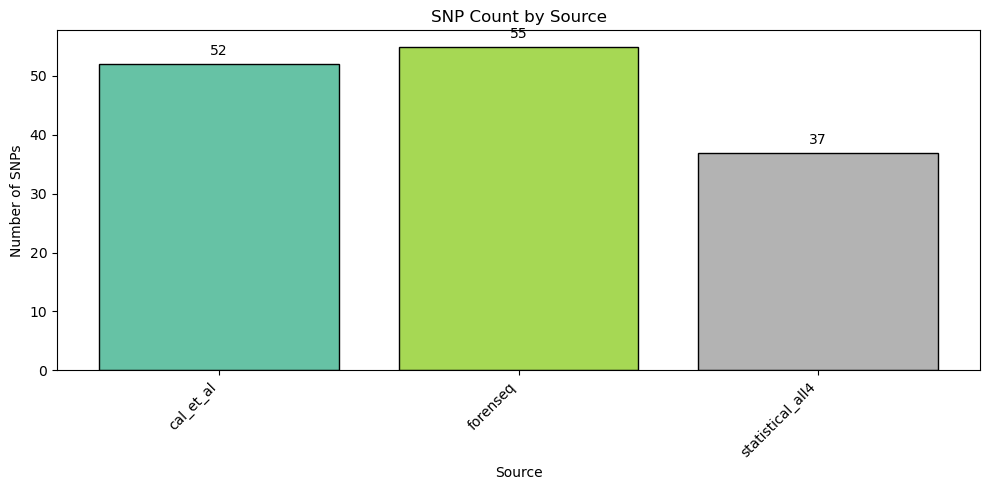

In [5]:
# Visualization: SNP counts
fig, ax = plt.subplots(figsize=(10, 5))

colors = plt.cm.Set2(np.linspace(0, 1, len(overview_df)))
bars = ax.bar(overview_df['Source'], overview_df['SNPs'], color=colors, edgecolor='black')

ax.set_xlabel('Source')
ax.set_ylabel('Number of SNPs')
ax.set_title('SNP Count by Source')
ax.set_xticklabels(overview_df['Source'], rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, overview_df['SNPs']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'snp_counts_by_source.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 3: Define Classifiers

In [6]:
# Define classifiers for comparison
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
    )
}

print(f"Classifiers: {len(classifiers)}")
for name in classifiers.keys():
    print(f"  - {name}")

Classifiers: 7
  - Random Forest
  - XGBoost
  - Logistic Regression
  - SVM (RBF)
  - K-Nearest Neighbors
  - Gradient Boosting
  - MLP Neural Network


## Step 4: K-Fold Cross-Validation on All Sources

In [7]:
# Run K-fold CV on all datasets
N_FOLDS = 5

all_results = []

for source_name, df in datasets.items():
    results = run_model_comparison(
        df=df,
        classifiers=classifiers,
        n_folds=N_FOLDS,
        source_name=source_name
    )
    all_results.append(results)

# Combine all results
results_df = pd.concat(all_results, ignore_index=True)

print(f"\n\n{'='*70}")
print("ALL RESULTS")
print(f"{'='*70}")
display(results_df)


Running 5-Fold CV on cal_et_al
Samples: 306, SNPs: 52, Classes: ['CHB', 'JPT', 'KHV']
  Random Forest: Acc=0.9085±0.0321, F1=0.9078
  XGBoost: Acc=0.9150±0.0433, F1=0.9144
  Logistic Regression: Acc=0.9021±0.0424, F1=0.9006
  SVM (RBF): Acc=0.9084±0.0436, F1=0.9086
  K-Nearest Neighbors: Acc=0.8431±0.0247, F1=0.8433
  Gradient Boosting: Acc=0.8920±0.0307, F1=0.8913
  MLP Neural Network: Acc=0.8364±0.0542, F1=0.8360

Running 5-Fold CV on forenseq
Samples: 306, SNPs: 55, Classes: ['CHB', 'JPT', 'KHV']
  Random Forest: Acc=0.6013±0.0174, F1=0.5997
  XGBoost: Acc=0.5590±0.0383, F1=0.5601
  Logistic Regression: Acc=0.6045±0.0668, F1=0.6049
  SVM (RBF): Acc=0.6080±0.0340, F1=0.6115
  K-Nearest Neighbors: Acc=0.4969±0.0361, F1=0.4987
  Gradient Boosting: Acc=0.5753±0.0436, F1=0.5766
  MLP Neural Network: Acc=0.5127±0.1004, F1=0.4920

Running 5-Fold CV on statistical_all4
Samples: 306, SNPs: 37, Classes: ['CHB', 'JPT', 'KHV']
  Random Forest: Acc=0.8169±0.0410, F1=0.8138
  XGBoost: Acc=0.8072

,Source,N_SNPs,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Recall_Mean,Train_Accuracy,Overfit_Gap
0,cal_et_al,52,Random Forest,0.908514,0.032066,0.907760,0.032656,0.914795,0.908514,1.000000,0.091486
1,cal_et_al,52,XGBoost,0.914966,0.043347,0.914387,0.043411,0.919625,0.914966,1.000000,0.085034
2,cal_et_al,52,Logistic Regression,0.902062,0.042432,0.900599,0.043956,0.909877,0.902062,1.000000,0.097938
3,cal_et_al,52,SVM (RBF),0.908408,0.043626,0.908601,0.043148,0.914596,0.908408,0.993466,0.085058
4,cal_et_al,52,K-Nearest Neighbors,0.843099,0.024744,0.843322,0.025843,0.867412,0.843099,0.886444,0.043345
5,cal_et_al,52,Gradient Boosting,0.892015,0.030703,0.891295,0.030103,0.898700,0.892015,1.000000,0.107985
6,cal_et_al,52,MLP Neural Network,0.836436,0.054216,0.836030,0.054176,0.841018,0.836436,0.907705,0.071269
7,forenseq,55,Random Forest,0.601269,0.017395,0.599683,0.014528,0.606494,0.601269,1.000000,0.398731
8,forenseq,55,XGBoost,0.558964,0.038295,0.560097,0.040634,0.566392,0.558964,1.000000,0.441036
9,forenseq,55,Logistic Regression,0.604548,0.066822,0.604856,0.069309,0.612266,0.604548,0.804724,0.200176


## Step 5: Performance Comparison Visualization

In [8]:
# Pivot table: Models as rows, Sources as columns
pivot_accuracy = results_df.pivot(index='Model', columns='Source', values='Accuracy_Mean')
pivot_f1 = results_df.pivot(index='Model', columns='Source', values='F1_Mean')

print("Accuracy by Model and Source:")
display(pivot_accuracy.round(4))

print("\nF1 Score by Model and Source:")
display(pivot_f1.round(4))

Accuracy by Model and Source:


Source,cal_et_al,forenseq,statistical_all4
Model,,,
Gradient Boosting,0.8920,0.5753,0.7810
K-Nearest Neighbors,0.8431,0.4969,0.5749
Logistic Regression,0.9021,0.6045,0.8627
MLP Neural Network,0.8364,0.5127,0.7944
Random Forest,0.9085,0.6013,0.8169
SVM (RBF),0.9084,0.6080,0.8955
XGBoost,0.9150,0.5590,0.8072



F1 Score by Model and Source:


Source,cal_et_al,forenseq,statistical_all4
Model,,,
Gradient Boosting,0.8913,0.5766,0.7788
K-Nearest Neighbors,0.8433,0.4987,0.5796
Logistic Regression,0.9006,0.6049,0.8607
MLP Neural Network,0.8360,0.4920,0.7827
Random Forest,0.9078,0.5997,0.8138
SVM (RBF),0.9086,0.6115,0.8945
XGBoost,0.9144,0.5601,0.8021


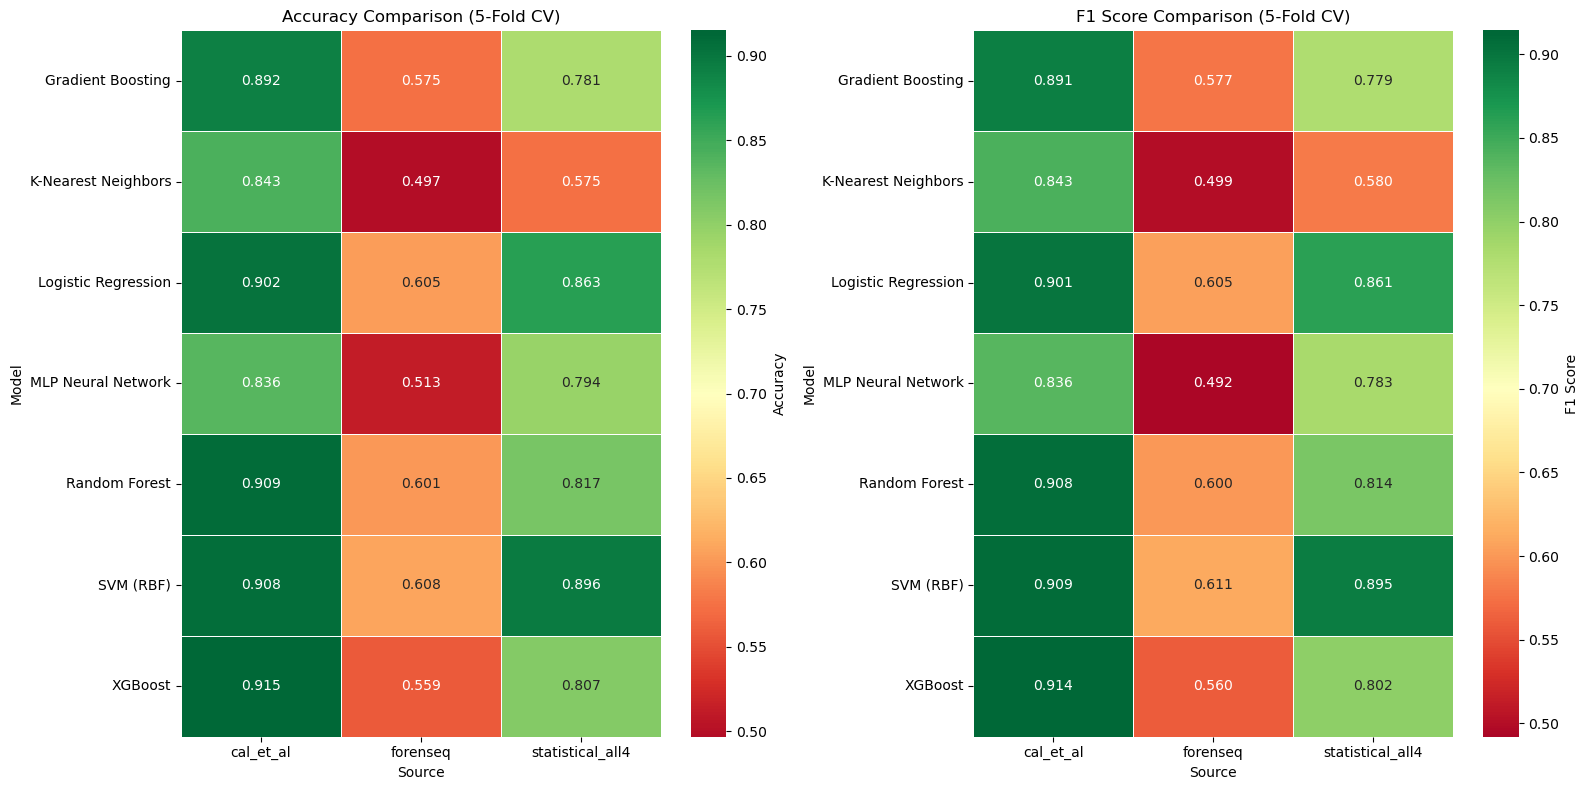

In [9]:
# Heatmap: Accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Accuracy heatmap
ax = axes[0]
sns.heatmap(pivot_accuracy, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.7, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Accuracy'})
ax.set_title(f'Accuracy Comparison ({N_FOLDS}-Fold CV)')
ax.set_xlabel('Source')
ax.set_ylabel('Model')

# F1 heatmap
ax = axes[1]
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.7, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'F1 Score'})
ax.set_title(f'F1 Score Comparison ({N_FOLDS}-Fold CV)')
ax.set_xlabel('Source')
ax.set_ylabel('Model')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'performance_heatmaps.png'), dpi=150, bbox_inches='tight')
plt.show()

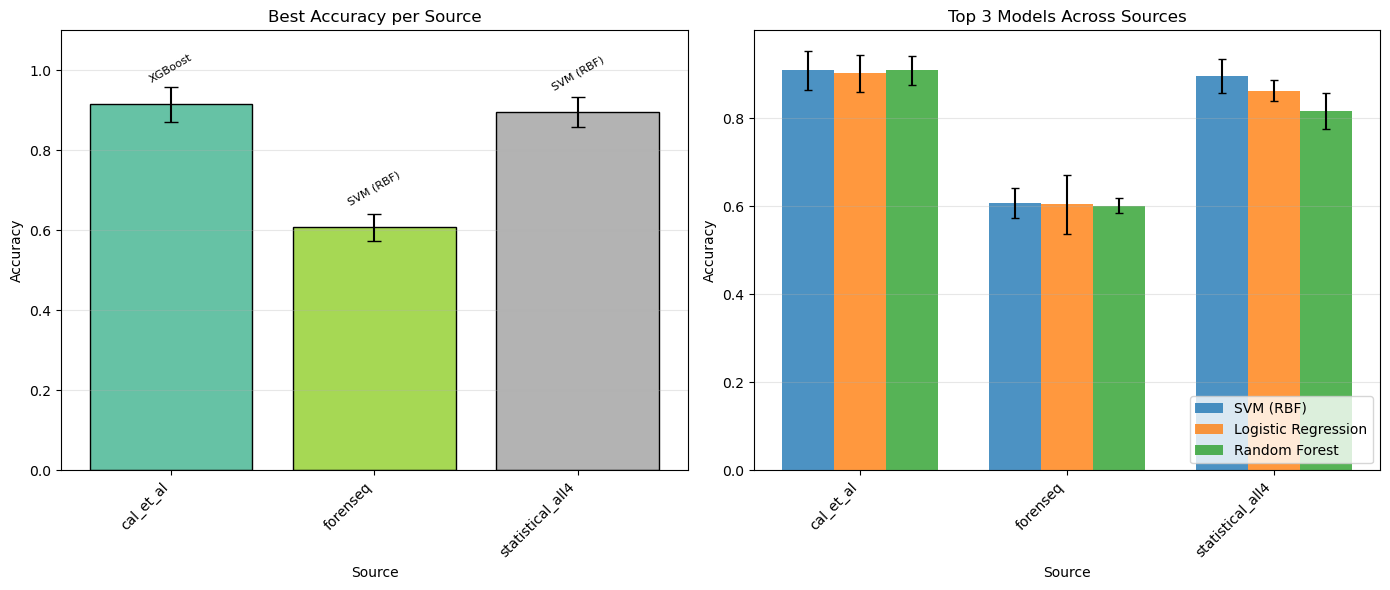

In [10]:
# Bar chart: Best model per source
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Best accuracy per source
ax = axes[0]
best_per_source = results_df.loc[results_df.groupby('Source')['Accuracy_Mean'].idxmax()]
colors = plt.cm.Set2(np.linspace(0, 1, len(best_per_source)))

bars = ax.bar(best_per_source['Source'], best_per_source['Accuracy_Mean'],
              yerr=best_per_source['Accuracy_Std'], color=colors, capsize=5, edgecolor='black')
ax.set_xlabel('Source')
ax.set_ylabel('Accuracy')
ax.set_title('Best Accuracy per Source')
ax.set_xticklabels(best_per_source['Source'], rotation=45, ha='right')
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Add model names
for bar, model in zip(bars, best_per_source['Model']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            model, ha='center', va='bottom', fontsize=8, rotation=30)

# Grouped bar: Compare sources for top 3 models
ax = axes[1]
top_models = results_df.groupby('Model')['Accuracy_Mean'].mean().nlargest(3).index.tolist()
sources = results_df['Source'].unique()

x = np.arange(len(sources))
width = 0.25

for i, model in enumerate(top_models):
    model_data = results_df[results_df['Model'] == model].set_index('Source').loc[sources]
    ax.bar(x + i * width, model_data['Accuracy_Mean'], width, label=model,
           yerr=model_data['Accuracy_Std'], capsize=3, alpha=0.8)

ax.set_xlabel('Source')
ax.set_ylabel('Accuracy')
ax.set_title('Top 3 Models Across Sources')
ax.set_xticks(x + width)
ax.set_xticklabels(sources, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'best_models_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 6: Confusion Matrices for Best Models

In [11]:
# Generate confusion matrices for best model of each source
conf_matrices_all = {}
class_names = None

for source_name, df in datasets.items():
    print(f"\nGenerating confusion matrices for: {source_name}")
    
    # Get best model for this source
    source_results = results_df[results_df['Source'] == source_name]
    best_model = source_results.loc[source_results['Accuracy_Mean'].idxmax(), 'Model']
    
    # Generate confusion matrix for best model only
    best_clf = {best_model: classifiers[best_model]}
    cm_dict, classes = generate_confusion_matrices(df, best_clf, test_size=0.2)
    
    conf_matrices_all[source_name] = {
        'model': best_model,
        'cm': cm_dict[best_model],
        'classes': classes
    }
    
    if class_names is None:
        class_names = classes
    
    print(f"  Best model: {best_model}")


Generating confusion matrices for: cal_et_al
  Best model: XGBoost

Generating confusion matrices for: forenseq
  Best model: SVM (RBF)

Generating confusion matrices for: statistical_all4
  Best model: SVM (RBF)


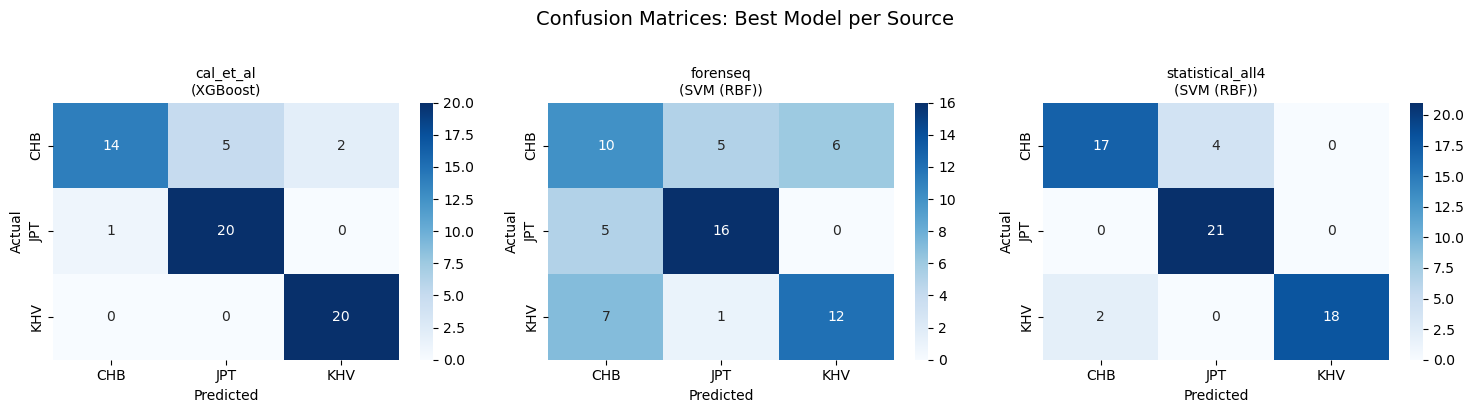

In [12]:
# Plot confusion matrices for all sources
n_sources = len(conf_matrices_all)
n_cols = min(3, n_sources)
n_rows = (n_sources + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_sources == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (source_name, data) in enumerate(conf_matrices_all.items()):
    ax = axes[idx]
    sns.heatmap(data['cm'], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=data['classes'], yticklabels=data['classes'])
    ax.set_title(f"{source_name}\n({data['model']})", fontsize=10)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Hide empty subplots
for idx in range(n_sources, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Confusion Matrices: Best Model per Source', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 7: Statistical Comparison

In [13]:
# Summary statistics per source
summary_stats = results_df.groupby('Source').agg({
    'N_SNPs': 'first',
    'Accuracy_Mean': ['mean', 'max', 'std'],
    'F1_Mean': ['mean', 'max'],
    'Overfit_Gap': 'mean'
}).round(4)

summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

print("Summary Statistics by Source:")
print("="*80)
display(summary_stats)

Summary Statistics by Source:


,N_SNPs_first,Accuracy_Mean_mean,Accuracy_Mean_max,Accuracy_Mean_std,F1_Mean_mean,F1_Mean_max,Overfit_Gap_mean
Source,,,,,,,
cal_et_al,52,0.8865,0.9150,0.0328,0.8860,0.9144,0.0832
forenseq,55,0.5654,0.6080,0.0452,0.5634,0.6115,0.3009
statistical_all4,37,0.7904,0.8955,0.1031,0.7874,0.8945,0.0966


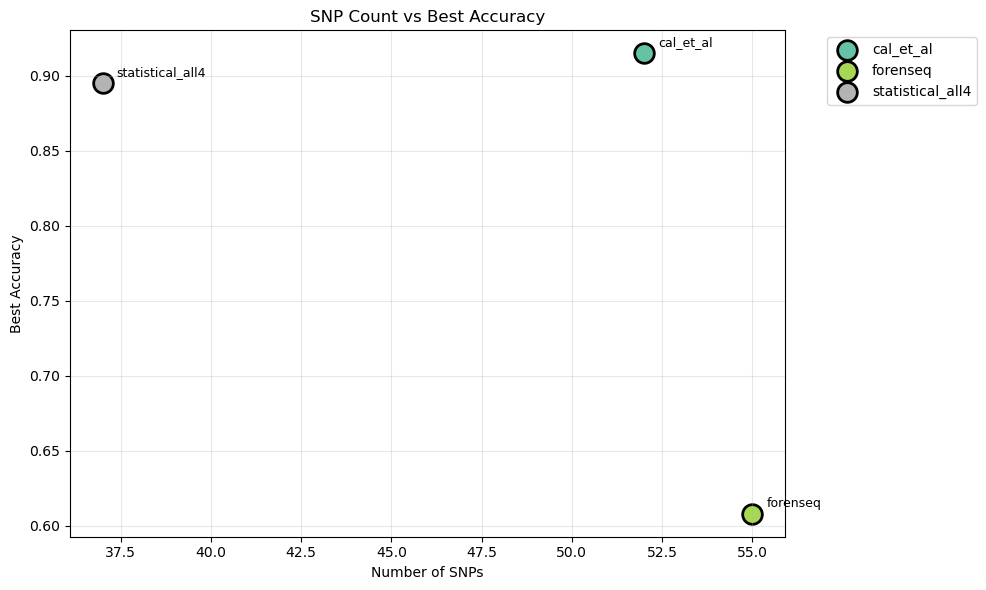

In [14]:
# SNPs vs Accuracy scatter
fig, ax = plt.subplots(figsize=(10, 6))

# Get best accuracy per source
best_per_source = results_df.loc[results_df.groupby('Source')['Accuracy_Mean'].idxmax()]

colors = plt.cm.Set2(np.linspace(0, 1, len(best_per_source)))

for i, (_, row) in enumerate(best_per_source.iterrows()):
    ax.scatter(row['N_SNPs'], row['Accuracy_Mean'], s=200, c=[colors[i]],
               edgecolors='black', linewidths=2, label=row['Source'])
    ax.annotate(row['Source'], (row['N_SNPs'], row['Accuracy_Mean']),
                xytext=(10, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Best Accuracy')
ax.set_title('SNP Count vs Best Accuracy')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'snps_vs_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 8: Save Results

In [15]:
# Save all results
results_path = str(PART2_DIR / "ml_comparison_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Results saved: {results_path}")

# Save pivot tables
pivot_accuracy.to_csv(str(PART2_DIR / "accuracy_by_source.csv"))
pivot_f1.to_csv(str(PART2_DIR / "f1_by_source.csv"))
print(f"Pivot tables saved")

# Create and save report
report_path = str(PART2_DIR / "ml_comparison_report.txt")
report = create_summary_report(results_df, report_path)

Results saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/ml_comparison_results.csv
Pivot tables saved
Report saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/ml_comparison_report.txt


## Summary

In [16]:
print("="*70)
print("KNOWN AISNPs ML COMPARISON SUMMARY")
print("="*70)

print(f"\nDatasets Compared: {len(datasets)}")
for name, df in datasets.items():
    n_snps = len([c for c in df.columns if c not in ['sample', 'pop', 'source']])
    print(f"  - {name}: {n_snps} SNPs")

print(f"\nClassifiers Tested: {len(classifiers)}")
print(f"Cross-Validation: {N_FOLDS}-Fold")

print(f"\nBest Performance per Source:")
for _, row in best_per_source.iterrows():
    print(f"  {row['Source']}: {row['Model']} ({row['Accuracy_Mean']:.4f} ± {row['Accuracy_Std']:.4f})")

# Overall best
overall_best = results_df.loc[results_df['Accuracy_Mean'].idxmax()]
print(f"\n★ Overall Best:")
print(f"  Source: {overall_best['Source']}")
print(f"  Model: {overall_best['Model']}")
print(f"  Accuracy: {overall_best['Accuracy_Mean']:.4f} ± {overall_best['Accuracy_Std']:.4f}")
print(f"  F1 Score: {overall_best['F1_Mean']:.4f}")

print(f"\nOutput Files:")
print(f"  - {PART2_DIR / 'ml_comparison_results.csv'}")
print(f"  - {PART2_DIR / 'ml_comparison_report.txt'}")
print(f"  - {GRAPHS_DIR / '*.png'} (plots)")

KNOWN AISNPs ML COMPARISON SUMMARY

Datasets Compared: 3
  - cal_et_al: 52 SNPs
  - forenseq: 55 SNPs
  - statistical_all4: 37 SNPs

Classifiers Tested: 7
Cross-Validation: 5-Fold

Best Performance per Source:
  cal_et_al: XGBoost (0.9150 ± 0.0433)
  forenseq: SVM (RBF) (0.6080 ± 0.0340)
  statistical_all4: SVM (RBF) (0.8955 ± 0.0380)

★ Overall Best:
  Source: cal_et_al
  Model: XGBoost
  Accuracy: 0.9150 ± 0.0433
  F1 Score: 0.9144

Output Files:
  - /home/Plutonium/Documents/BioinfoMidterm/output/part2/ml_comparison_results.csv
  - /home/Plutonium/Documents/BioinfoMidterm/output/part2/ml_comparison_report.txt
  - /home/Plutonium/Documents/BioinfoMidterm/graphs/part2/*.png (plots)
